In [1]:
import pandas as pd
from pyspi.calculator import Calculator
import numpy as np
from copy import deepcopy
import glob
import os
import random
import neuromaps
from neuromaps.parcellate import Parcellater
from nibabel import freesurfer as fs
from neuromaps.datasets import fetch_annotation
from pathlib import Path

# Set seed to 127
random.seed(127)

# Add connectome workbench to path
os.environ['PATH'] = os.environ['PATH'] + ':/Applications/workbench/bin_macosx64'

%load_ext rpy2.ipython

In [2]:
%%R 

suppressPackageStartupMessages({
    library(broom)
    library(circlize)
    library(ComplexHeatmap)
    library(cowplot)
    library(dendextend)
    library(FactoMineR)
    library(GGally)
    library(ggseg)
    library(glue)
    library(grid)
    library(patchwork)
    library(see)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

# Load in the data and filter to directed information (DI) with a Gaussian estimator

In [41]:
data_path = "/Users/abry4213/data/HCP100/"

# Load in all the pyspi homotopic res
all_homotopic_res = pd.concat([pd.read_csv(f) for f in glob.glob(data_path + "time_series_features/pyspi/*.csv")])
di_gaussian_homotopic_res = all_homotopic_res.query("SPI=='di_gaussian'")
di_kozachenko_homotopic_res = all_homotopic_res.query("SPI=='di_kozachenko'")

# Compute the mean value for each base_region_to in di_gaussian_homotopic_res
di_gaussian_homotopic_res_mean = (di_gaussian_homotopic_res
                                  .groupby("base_region_to")['value']
                                  .mean()
                                  .reset_index()
                                  .rename(columns={"base_region_to": "Base_Region",
                                                   "value": "Mean_DI_Gaussian"}))

### Let's plot the overall distribution of Gaussian DI values in each brain region, using a raincloud plot

`summarise()` has grouped output by 'Subject'. You can override using the
`.groups` argument.


/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


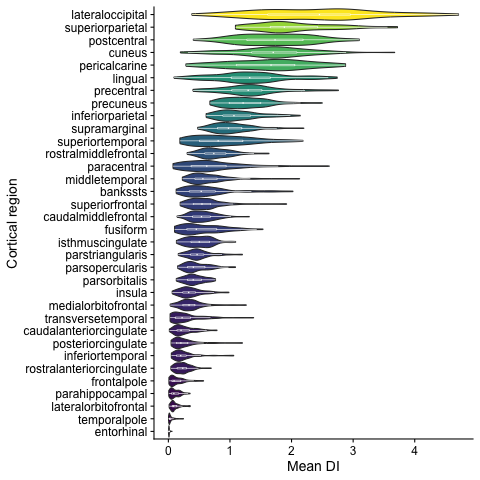

In [4]:
%%R -i di_gaussian_homotopic_res

di_gaussian_homotopic_res %>%
  group_by(Subject, base_region_to) %>%
  summarise(mean_DI = mean(value, na.rm=T)) %>%
  ungroup() %>%
  group_by(base_region_to) %>%
  mutate(mean_region_DI = mean(mean_DI)) %>%
  ungroup() %>%
  mutate(base_region_to = fct_reorder(base_region_to, mean_DI, .fun=mean)) %>%
  ggplot(data=., mapping=aes(y=base_region_to, x=mean_DI, fill=mean_region_DI)) +
  geom_violin(scale="width") +
  geom_boxplot(width=0.1, fill=NA, outlier.shape = NA, color="white",lwd=0.3) +
  theme(legend.position="none") +
  xlab("Mean DI") +
  ylab("Cortical region") +
  scale_fill_viridis_c(na.value = "white")

### Let's plot the mean Gaussian DI in each brain region, using the left cortical surface for visualization

/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'


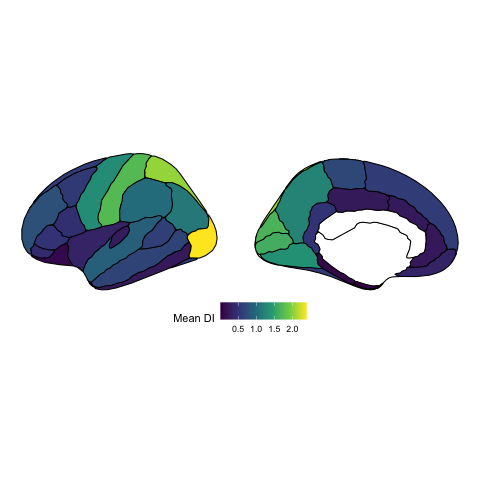

In [31]:
%%R -i di_gaussian_homotopic_res -o mean_di_gaussian_homotopic_res

# Let's plot this in the brain
mean_di_gaussian_homotopic_res <- di_gaussian_homotopic_res %>%
  group_by(base_region_to) %>%
  summarise(mean_DI = mean(value, na.rm=T),
            sd_DI = sd(value, na.rm=T))
            
mean_di_gaussian_homotopic_res %>%
  ungroup() %>%
  mutate(label = glue("lh_{base_region_to}")) %>%
  left_join(., as_tibble(dk)) %>%
  ggseg(atlas = dk, mapping = aes(fill = mean_DI),
        position = "stacked", colour = "black", hemisphere="left") +
  theme_void() +
  labs(fill = "Mean DI") +
  theme(plot.title = element_blank(),
        legend.position = "bottom") +
  scale_fill_viridis_c(na.value = "white")

### What is the left-right asymmetry in Gaussian-DI values?

`summarise()` has grouped output by 'Subject'. You can override using the
`.groups` argument.


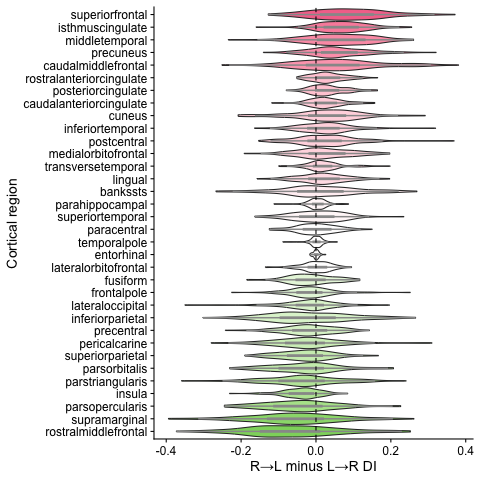

In [6]:
%%R -i di_gaussian_homotopic_res -o region_DI_subtract_diffs

# What is the difference in DI by brain region?
region_DI_subtract_diffs <- di_gaussian_homotopic_res %>%
  group_by(Subject, base_region_to) %>%
  summarise(DI_LR = value[hemi_from=="left"],
            DI_RL = value[hemi_from=="right"]) %>%
  rowwise() %>%
  mutate(RL_minus_LR = DI_RL - DI_LR) %>%
  ungroup() %>%
  group_by(base_region_to) %>%
  mutate(mean_RL_minus_LR = mean(RL_minus_LR),
         sd_RL_minus_LR = sd(RL_minus_LR)) %>%
  ungroup() %>%
  mutate(base_region_to = fct_reorder(base_region_to, mean_RL_minus_LR, .fun=median))

region_DI_subtract_diffs %>%
  ggplot(data=., mapping=aes(y=base_region_to, x=RL_minus_LR, fill=mean_RL_minus_LR)) +
  geom_violin(scale="width") +
  geom_boxplot(width=0.1, lwd=0.7, outlier.shape=NA, color="gray60") +
  scale_fill_gradient2(high="#f47599", low="#5dc636", mid="white") +
  geom_vline(xintercept=0, linetype=2) +
  theme(legend.position="none")+
  xlab("R\u2192L minus L\u2192R DI") +
  ylab("Cortical region")

Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'


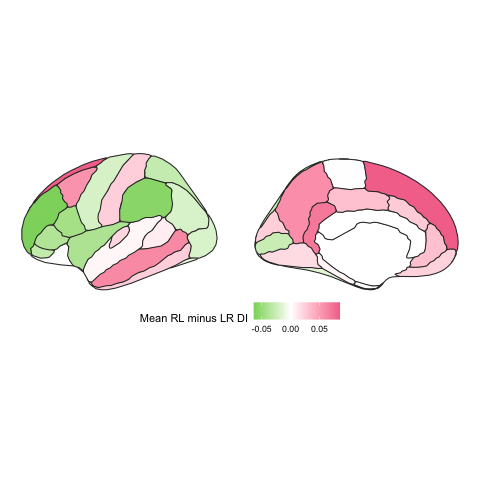

In [7]:
%%R -i region_DI_subtract_diffs

# Plot in the brain
region_DI_subtract_diffs %>%
  distinct(base_region_to, mean_RL_minus_LR) %>%
  mutate(label = glue("lh_{base_region_to}")) %>%
  left_join(., as_tibble(dk)) %>%
  ggseg(atlas = dk, mapping = aes(fill = mean_RL_minus_LR),
        position = "stacked", colour = "gray20", hemisphere="left") +
  theme_void() +
  scale_fill_gradient2(high="#f47599", low="#5dc636", mid="white", na.value = "white") +
  labs(fill = "Mean RL minus LR DI") +
  theme(plot.title = element_blank(),
        legend.position = "bottom")

## Other functional/structural annotations to consider

In [30]:
if not os.path.exists("neuromaps_atlases.csv"):
    nm_atlas_df = pd.read_csv('neuromaps_atlases.csv')

    # Read in brain region lookup table
    brain_region_info = pd.read_csv("../Brain_Region_Info.csv")

    # Define the left- and right-hemisphere Desikan-Killiany (DK) atlas
    lh_dk = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage/lh.aparc.annot"
    rh_dk = "/Users/abry4213/data/neuroimaging_atlases/surfaces/DesikanKilliany/fsaverage/rh.aparc.annot"

    # Convert the DK atlas to gifti format
    dk_gifti = neuromaps.images.annot_to_gifti((lh_dk, rh_dk), background=None)
    dk_gifti = neuromaps.images.relabel_gifti(dk_gifti)

    # Fit a Parcellator object
    parc = Parcellater(dk_gifti, 'fsaverage', resampling_target='parcellation')

    # Loop through each atlas, extract the values in Desikan-Killiany space, and create a dataframe
    all_dk_neuromaps_res_list = []
    for i, row in nm_atlas_df.iterrows():
        this_row_category = row['Category']
        this_row_desc = row['Description']
        source, desc, space, den = row['Filename'].split('-')

        try:
            print(f"Fetching {source} {desc} {space} {den}")
            this_atlas_data = fetch_annotation(source=source, desc=desc, space=space, 
                                                den=den, data_dir=Path("/Users/abry4213/neuromaps-data"))
            
            # Extract this atlas' values in Desikan-Killiany space
            parc_iter = deepcopy(parc)
            this_atlas_data_in_dk = parc_iter.fit_transform(this_atlas_data, space)

            # Create a dataframe
            this_atlas_data_in_dk_df = pd.DataFrame({'Category': this_row_category,
                                                        'Description': this_row_desc,
                                                        'Region_Index': range(len(this_atlas_data_in_dk)),
                                                        'Value': this_atlas_data_in_dk}).merge(brain_region_info, on="Region_Index")
            
            # Append to the list
            all_dk_neuromaps_res_list.append(this_atlas_data_in_dk_df)
        
        except Exception as e:
            print(f"Error parcellating {source} {desc} {space} {den}: {e}")
            continue

    # Concatenate all the dataframes
    all_dk_neuromaps_res = pd.concat(all_dk_neuromaps_res_list)

    # Save the results
    all_dk_neuromaps_res.to_csv("all_dk_neuromaps_res.csv", index=False)

In [42]:
all_dk_neuromaps_res_hemi_avg = all_dk_neuromaps_res.groupby(['Category', 'Description', 'Base_Region'])['Value'].mean().reset_index()
all_dk_neuromaps_res_hemi_avg

,Category,Description,Base_Region,Value
0,Cognition,Neurosynth PC1,bankssts,0.001086
1,Cognition,Neurosynth PC1,caudalanteriorcingulate,-0.000033
2,Cognition,Neurosynth PC1,caudalmiddlefrontal,-0.000092
3,Cognition,Neurosynth PC1,cuneus,-0.000204
4,Cognition,Neurosynth PC1,entorhinal,-0.001870
...,...,...,...,...
1321,Transcriptome,PC1 of Allen Human Brain Atlas,superiorparietal,0.569862
1322,Transcriptome,PC1 of Allen Human Brain Atlas,superiortemporal,-0.575586
1323,Transcriptome,PC1 of Allen Human Brain Atlas,supramarginal,0.141634
1324,Transcriptome,PC1 of Allen Human Brain Atlas,temporalpole,-2.057375


In [48]:
# Merge the dataframes on 'Base_Region'
merged_df = pd.merge(all_dk_neuromaps_res_hemi_avg, di_gaussian_homotopic_res_mean, left_on='Base_Region', right_on='Base_Region')

# Group by 'Category' and 'Description' and compute the Spearman correlation
spearman_corrs_di_gaussian = (merged_df
                              .groupby(['Category', 'Description'])
                              .apply(lambda x: x[['Value', 'Mean_DI_Gaussian']]
                              .corr(method='spearman').iloc[0, 1])
                              .reset_index()
                              .assign(SPI = 'di_gaussian'))

# Rename the columns for clarity
spearman_corrs_di_gaussian.columns = ['Category', 'Description', 'Spearman_Correlation', 'SPI']

# Display the results
spearman_corrs_di_gaussian

/var/folders/rn/z0683sns3tz7b_k0cbf8ft8w0000gq/T/ipykernel_66370/1648636007.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spearman_corrs_di_gaussian = (merged_df


,Category,Description,Spearman_Correlation,SPI
0,Cognition,Neurosynth PC1,0.636669,di_gaussian
1,Development,Evolutionary and developmental expansion,0.109549,di_gaussian
2,Functional hierarchy,Margulies PG1,-0.551719,di_gaussian
3,Functional hierarchy,Sensory-association mean rank axis,-0.559969,di_gaussian
4,Metabolism,Cerebral blood flow,0.500993,di_gaussian
5,Metabolism,Cerebral blood volume,0.359511,di_gaussian
6,Metabolism,Glucose metabolism,0.596639,di_gaussian
7,Metabolism,Oxygen metabolism,0.711841,di_gaussian
8,Microstructure,T1w vs. T2w MRI signal,0.686784,di_gaussian
9,Morphometry,Cortical thickness,-0.550191,di_gaussian
